# The food vision 101 project

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2024 <br>

Thi project is about to rival the CNN model that was build and publiced by the authors of the paper <b>[DeepFood: Deep Learning-Based Food Image Recognition for Computer-Aided Dietary Assessment 2016](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)</b>. The paper addresses the challenge of accurately documenting dietary caloric intake, which is crucial for managing weight loss and understanding dietary habits. Traditional methods for dietary assessment, such as 24-hour recalls and food frequency questionnaires, rely on an individual's memory, which can introduce bias and inaccuracies. To overcome these limitations, the paper proposes a computer-aided technical solution using deep learning-based food image recognition algorithms. <b>The core innovation of the paper is the development of a new Convolutional Neural Network (CNN)-based algorithm for food image recognition with the highest score reaching 77,4%</b>.

So our goal is to create a CNN that reach or surpass this score in the same dataset <b>(Food-101)</b>.

|                 | 🍔🍝 About the Bataset 🥪🥞 |
|-----------------|-------------------------------|
| Dataset source  |      TensorFlow Datasets      | 
| Train data      |         75,750 images         | 
| Test data       |         25,250 images         | 
| Mixed precision |              Yes              |
| Data loading    |    Performanant tf.data API   |  
| Target results  |      77.4% top-1 accuracy     | 

## Load libraries

In [1]:
# Helper Functions
from helper_functions import plot_loss_accuracy_curves
from helper_functions import random_img_show
from helper_functions import walk_through_dir
from helper_functions import preprocess_img
from helper_functions import check_models_have_close_weights

# Data manipulation
import pandas as pd
import numpy as np

# Modeling and Mixed percision training
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

2024-03-09 20:51:40.436462: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 20:51:40.458785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 20:51:40.458797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 20:51:40.459991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 20:51:40.466050: I tensorflow/core/platform/cpu_feature_guar

## Data Exploration

> Access the data images from the tensorflow datasets

In [2]:
# Load in the data (this wi ll take some time..)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True,
                                             data_dir='Dataset/'
                                            )

2024-03-09 20:51:41.624435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 20:51:41.637122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 20:51:41.637158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 20:51:41.639108: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 20:51:41.639138: I external/local_xla/xla/stream_executor

> A directory walk throught that we can see each directory and the number of images inside

In [3]:
walk_through_dir('Dataset/')

There are 2 directories and 0 images in 'Dataset/'.
There are 1 directories and 2 images in 'Dataset/downloads'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz'.
There are 2 directories and 2 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101'.
There are 101 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images/apple_pie'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cv

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

> Class labels presentation

In [5]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
print(len(class_names))

101


> Plot random images

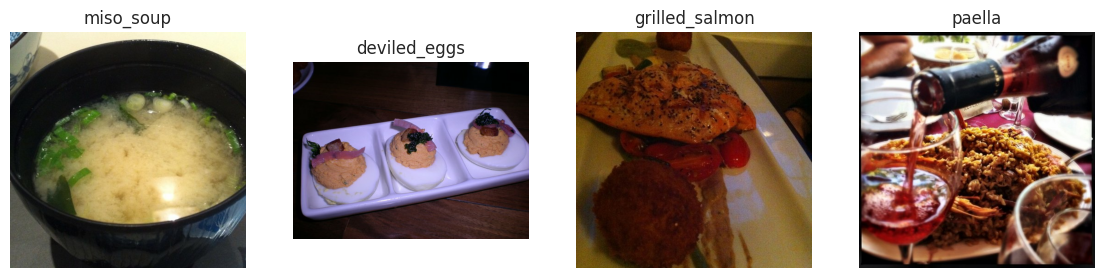

In [7]:
random_img_show(train_data, class_names)

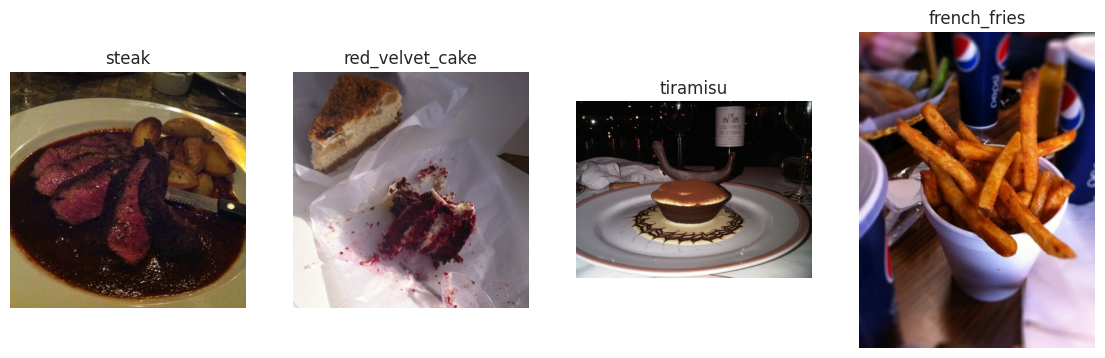

In [8]:
random_img_show(test_data, class_names)

> The images in both train and test dataset have no standar shape

In [9]:
# Output info about our training sample
for image, label in train_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 33
  Class name (str form): edamame
        


In [10]:
# Output info about our training sample
for image, label in test_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 65
  Class name (str form): mussels
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 70
  Class name (str form): pad_thai
        


> Shape variance in both train and test datasets

In [11]:
train_shape_variance = set()

for image, label in train_data:
    train_shape_variance.add(image.shape)
    
train_shape_variance

{TensorShape([122, 512, 3]),
 TensorShape([140, 512, 3]),
 TensorShape([165, 512, 3]),
 TensorShape([181, 512, 3]),
 TensorShape([182, 512, 3]),
 TensorShape([188, 512, 3]),
 TensorShape([210, 512, 3]),
 TensorShape([218, 512, 3]),
 TensorShape([220, 512, 3]),
 TensorShape([222, 512, 3]),
 TensorShape([225, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([228, 512, 3]),
 TensorShape([229, 512, 3]),
 TensorShape([230, 512, 3]),
 TensorShape([231, 512, 3]),
 TensorShape([232, 512, 3]),
 TensorShape([236, 512, 3]),
 TensorShape([239, 512, 3]),
 TensorShape([241, 512, 3]),
 TensorShape([243, 512, 3]),
 TensorShape([246, 512, 3]),
 TensorShape([247, 512, 3]),
 TensorShape([249, 512, 3]),
 TensorShape([252, 512, 3]),
 TensorShape([253, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([257, 512, 3]),
 TensorShape([259, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([265, 512, 3]),
 TensorShape([266, 512, 3]),
 TensorShape([267, 512, 3]),
 TensorShape([

In [12]:
len(train_shape_variance)

448

In [13]:
test_shape_variance = set()

for image, label in test_data:
    test_shape_variance.add(image.shape)

test_shape_variance

{TensorShape([213, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([260, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([268, 512, 3]),
 TensorShape([271, 512, 3]),
 TensorShape([272, 512, 3]),
 TensorShape([276, 512, 3]),
 TensorShape([281, 512, 3]),
 TensorShape([282, 512, 3]),
 TensorShape([287, 512, 3]),
 TensorShape([288, 512, 3]),
 TensorShape([289, 512, 3]),
 TensorShape([290, 512, 3]),
 TensorShape([291, 512, 3]),
 TensorShape([293, 512, 3]),
 TensorShape([294, 512, 3]),
 TensorShape([295, 512, 3]),
 TensorShape([298, 512, 3]),
 TensorShape([299, 512, 3]),
 TensorShape([301, 512, 3]),
 TensorShape([304, 512, 3]),
 TensorShape([305, 512, 3]),
 TensorShape([306, 512, 3]),
 TensorShape([307, 512, 3]),
 TensorShape([308, 512, 3]),
 TensorShape([309, 512, 3]),
 TensorShape([310, 512, 3]),
 TensorShape([312, 512, 3]),
 TensorShape([313, 512, 3]),
 TensorShape([314, 512, 3]),
 TensorShape([316, 512, 3]),
 TensorShape([

In [14]:
len(test_shape_variance)

302

> Images will also need normalization

In [15]:
for image, label in train_data.take(1):
    print(image.numpy())

[[[ 95  95  25]
  [ 87  87  17]
  [ 96  93  26]
  ...
  [178 189 191]
  [180 191 193]
  [178 189 191]]

 [[ 92  92  22]
  [ 86  86  16]
  [ 91  88  21]
  ...
  [183 194 196]
  [184 195 197]
  [180 191 193]]

 [[ 97  94  25]
  [ 92  89  20]
  [ 89  86  19]
  ...
  [187 198 200]
  [185 199 200]
  [181 195 196]]

 ...

 [[205 196 155]
  [205 196 155]
  [203 194 155]
  ...
  [216 228 226]
  [214 226 224]
  [207 219 217]]

 [[209 197 155]
  [210 198 156]
  [207 198 159]
  ...
  [216 228 226]
  [212 224 222]
  [212 224 222]]

 [[202 191 146]
  [207 195 153]
  [207 198 157]
  ...
  [217 229 227]
  [213 225 223]
  [219 231 229]]]


In [16]:
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

## Pre-modeling Preparation

> In order to process tha images efficiently and train the model the faster that we can, we will need to modify the images and the way that the images are processed by the gpu and cpu. So, we will create batches of the images and enable the multitasking of the computer in order to load batches of images and augment them, while the gpu is training the model with the previous batch of images.

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

> Lets also create callback functions that will save our models progress and to early stop our models training if the model doesn't learn anything in a amount of epochs.

In [19]:
# Initialize the path that will save the model
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

# Create ModelCheckpoint callback to save model's progress
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0, # don't print out whether or not model is being saved 
                                                     ) 

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=2, # if val loss decreases for 2 epochs in a row, stop training
                                                 )

In [21]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Modeling

> The modeling is beeing performed in a Geforce RTX 3060 with 12.4 score of computational capabilities. This gpu enables the mixed percision training and the model will train and perform faster than without mixed percision.

In [22]:
!nvidia-smi

Sat Mar  9 20:52:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P5             18W /  170W |   10524MiB /  12288MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-03-09 20:52:01.764532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

> As for the modeling we will used already trained model in the image recognition cause we don't have the resources and the time to create from scratch a model capable to outperforme the model of the paper. So with the help of transfer learning we will take existing models and fine tune them in our situation. The model that we choosen is the **EfficientNetV2B0** and we hope to as its name says. Lets extract the model.

In [26]:
# Create base model
input_shape = (224, 224, 3)
model_name = 'EfficientNetV2B0'
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

In [27]:
print(f'Number of layers: {len(base_model.layers)}')
for number, layer in enumerate(base_model.layers):
    print(f'{number}.  {type(layer).__name__}')

Number of layers: 270
0.  InputLayer
1.  Rescaling
2.  Normalization
3.  Conv2D
4.  BatchNormalization
5.  Activation
6.  Conv2D
7.  BatchNormalization
8.  Activation
9.  Conv2D
10.  BatchNormalization
11.  Activation
12.  Conv2D
13.  BatchNormalization
14.  Conv2D
15.  BatchNormalization
16.  Activation
17.  Conv2D
18.  BatchNormalization
19.  Dropout
20.  Add
21.  Conv2D
22.  BatchNormalization
23.  Activation
24.  Conv2D
25.  BatchNormalization
26.  Conv2D
27.  BatchNormalization
28.  Activation
29.  Conv2D
30.  BatchNormalization
31.  Dropout
32.  Add
33.  Conv2D
34.  BatchNormalization
35.  Activation
36.  DepthwiseConv2D
37.  BatchNormalization
38.  Activation
39.  GlobalAveragePooling2D
40.  Reshape
41.  Conv2D
42.  Conv2D
43.  Multiply
44.  Conv2D
45.  BatchNormalization
46.  Conv2D
47.  BatchNormalization
48.  Activation
49.  DepthwiseConv2D
50.  BatchNormalization
51.  Activation
52.  GlobalAveragePooling2D
53.  Reshape
54.  Conv2D
55.  Conv2D
56.  Multiply
57.  Conv2D
58.  B

> Create the model

In [28]:
# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="avg_pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

> Ensuring we use mixed precision in our training for faster computations

In [30]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
avg_pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [31]:
for layer in base_model.layers[:20]: # only check the first 20 layers to save output space
    print(type(layer).__name__, layer.trainable, layer.dtype, layer.dtype_policy)

InputLayer False float32 <Policy "float32">
Rescaling False float32 <Policy "mixed_float16">
Normalization False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Dropout False float32 <Policy 

> Train the model for some epochs in order to train the new layers we added.

In [32]:
history = model.fit(train_data, 
                    epochs=4,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/4


2024-03-09 20:52:07.024751: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 20:52:07.374062: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-09 20:52:07.455001: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   3/2368 [..............................] - ETA: 1:00 - loss: 4.7334 - accuracy: 0.0000e+00   

2024-03-09 20:52:08.638224: I external/local_xla/xla/service/service.cc:168] XLA service 0x5614a9bbf4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-09 20:52:08.638258: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-09 20:52:08.642954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710010328.711945   91227 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - 68s 27ms/step - loss: 1.7487 - accuracy: 0.5749 - val_loss: 1.1390 - val_accuracy: 0.7007
Epoch 2/4
2368/2368 [==============================] - 63s 26ms/step - loss: 1.2118 - accuracy: 0.6876 - val_loss: 1.0293 - val_accuracy: 0.7304
Epoch 3/4
2368/2368 [==============================] - 62s 26ms/step - loss: 1.0641 - accuracy: 0.7216 - val_loss: 0.9948 - val_accuracy: 0.7331
Epoch 4/4
2368/2368 [==============================] - 62s 26ms/step - loss: 0.9692 - accuracy: 0.7453 - val_loss: 0.9742 - val_accuracy: 0.7439


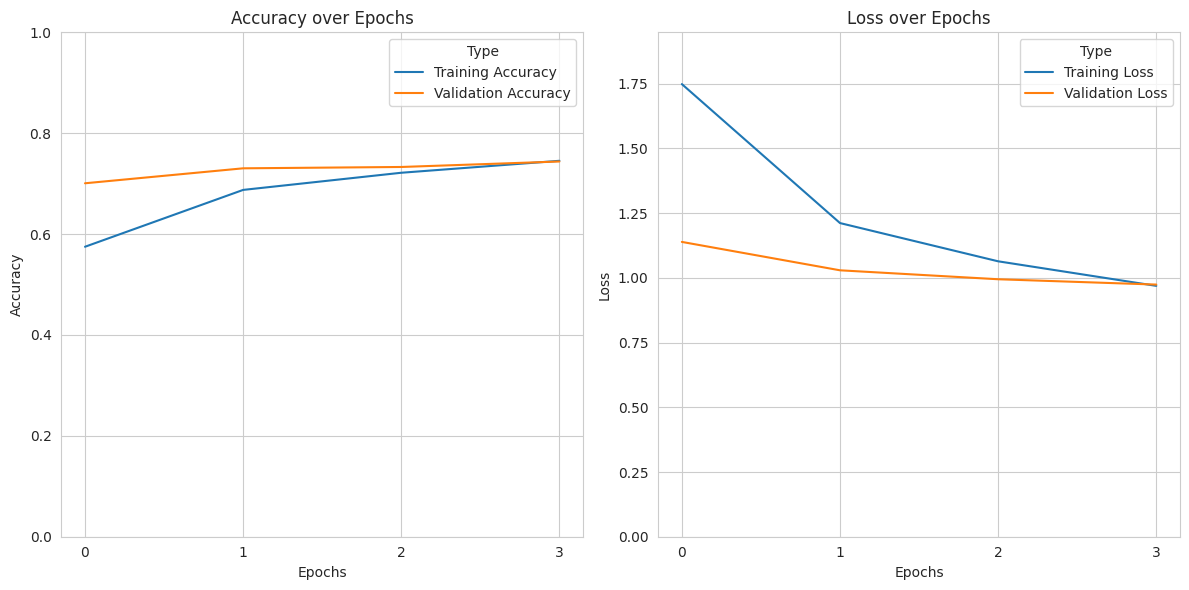

In [33]:
plot_loss_accuracy_curves(history)

In [34]:
model.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9719 - accuracy: 0.7354


[0.9719064831733704, 0.7354455590248108]

In [35]:
base_model_path = 'models/base_model/'
model.save(base_model_path)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a846d0>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a846d0>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a871c0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a871c0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353bb490>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353bb490>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353dc6d0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353dc6d0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a846d0>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a846d0>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a871c0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c35a871c0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353bb490>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353bb490>, 140034264015344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353dc6d0>, 140034264015584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5c353dc6d0>, 140034264015584), {}).


INFO:tensorflow:Assets written to: models/base_model/assets


INFO:tensorflow:Assets written to: models/base_model/assets


## Fine Tuning

### Last 20 layers

In [36]:
model_ft_l20 = tf.keras.models.load_model(base_model_path)

In [37]:
check_models_have_close_weights(model_ft_l20, model)

Both models have the same weights in all layers


> Lets unfreeze the last layers of the model in order to train the layers that take the decisions of the efficientnet model.

In [38]:
# Unfreeze the layers
model_ft_l20.layers[1].trainable = True
for layer in model_ft_l20.layers[1].layers[:-20]:
    layer.trainable = False

count = 0
for layer in model_ft_l20.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

efficientnetv2-b0
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: False
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True
Trainable: True


In [39]:
model_ft_l20.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

> Recompile the model in order to adjust the learning rate to x10 lower cause we dont want to modify a lot the weight in the unfrozen layers.

In [40]:
model_ft_l20.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [41]:
fine_tune_l20_history = model_ft_l20.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 82s 33ms/step - loss: 0.8065 - accuracy: 0.7855 - val_loss: 0.8762 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 76s 32ms/step - loss: 0.6847 - accuracy: 0.8175 - val_loss: 0.8680 - val_accuracy: 0.7654 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 76s 32ms/step - loss: 0.5663 - accuracy: 0.8467 - val_loss: 0.8615 - val_accuracy: 0.7733 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - 75s 32ms/step - loss: 0.4545 - accuracy: 0.8786 - val_loss: 0.9041 - val_accuracy: 0.7699 - lr: 1.0000e-04


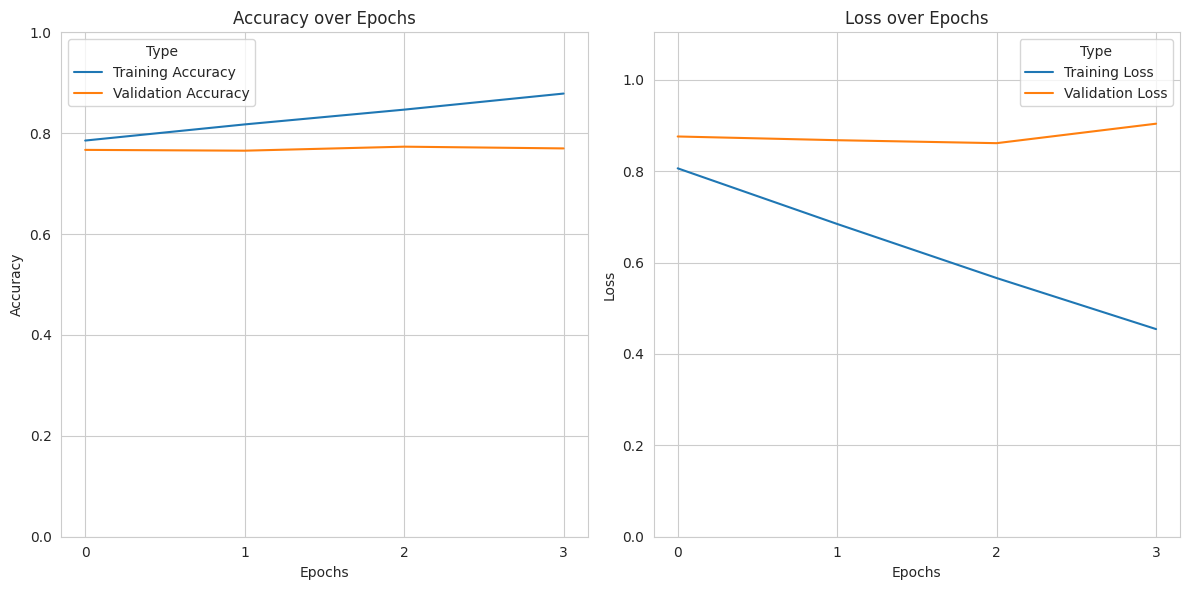

In [42]:
plot_loss_accuracy_curves(fine_tune_l20_history)

In [43]:
model_ft_l20.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9092 - accuracy: 0.7617


[0.9091851115226746, 0.7617029547691345]

### Last and first 20 layers

In [44]:
model_ft_l20_f20 = tf.keras.models.load_model(base_model_path)

In [45]:
check_models_have_close_weights(model_ft_l20_f20, model)

Both models have the same weights in all layers


In [46]:
# Freeze all layers in efficient net model.
model_ft_l20_f20.layers[1].trainable = True

# Unfreeze the first and last 20 layers
for layer in model_ft_l20_f20.layers[1].layers[20:-20]:
    layer.trainable = False

count = 0
for layer in model_ft_l20_f20.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2Bo model: 40


In [47]:
model_ft_l20_f20.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [48]:
model_ft_l20_f20.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [49]:
fine_tune_l20_f20_history = model_ft_l20_f20.fit(train_data,
                                                 epochs=4,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=[early_stopping, reduce_lr]
                                                )

Epoch 1/4
2368/2368 [==============================] - 175s 71ms/step - loss: 0.8015 - accuracy: 0.7865 - val_loss: 0.8557 - val_accuracy: 0.7709 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6715 - accuracy: 0.8187 - val_loss: 0.8289 - val_accuracy: 0.7741 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 168s 71ms/step - loss: 0.5518 - accuracy: 0.8518 - val_loss: 0.8432 - val_accuracy: 0.7775 - lr: 1.0000e-04
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 0.4398 - accuracy: 0.8813
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 169s 71ms/step - loss: 0.4398 - accuracy: 0.8813 - val_loss: 0.8697 - val_accuracy: 0.7760 - lr: 1.0000e-04


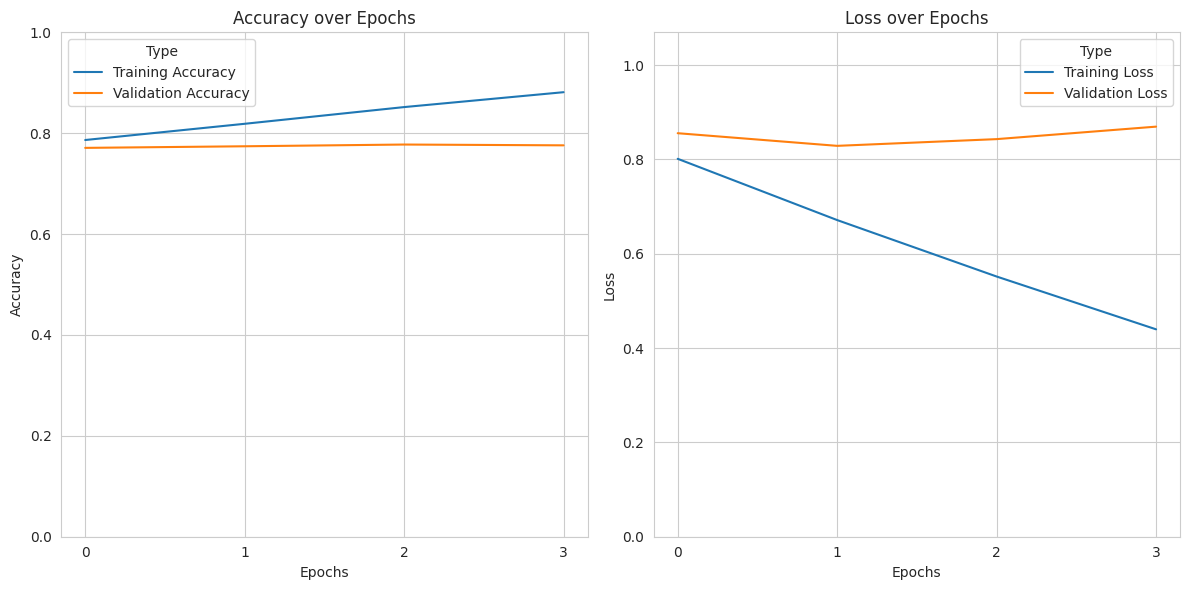

In [50]:
plot_loss_accuracy_curves(fine_tune_l20_f20_history)

In [51]:
model_ft_l20_f20.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.8758 - accuracy: 0.7684


[0.8757661581039429, 0.7684356570243835]

### Last 50 layers

In [52]:
model_ft_l50 = tf.keras.models.load_model(base_model_path)

In [53]:
check_models_have_close_weights(model_ft_l50, model)

Both models have the same weights in all layers


In [55]:
model_ft_l50.layers[1].trainable = True

for layer in model_ft_l50.layers[1].layers[:-50]:
    layer.trainable = False

count = 0
for layer in model_ft_l50.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2Bo model: 50


In [56]:
model_ft_l50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [58]:
model_ft_l50.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [60]:
fine_tune_l50_history = model_ft_l50.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 103s 41ms/step - loss: 0.8042 - accuracy: 0.7847 - val_loss: 0.8322 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 95s 40ms/step - loss: 0.6014 - accuracy: 0.8380 - val_loss: 0.8274 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 95s 40ms/step - loss: 0.4030 - accuracy: 0.8916 - val_loss: 0.9033 - val_accuracy: 0.7701 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9393
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 96s 41ms/step - loss: 0.2324 - accuracy: 0.9393 - val_loss: 1.0376 - val_accuracy: 0.7656 - lr: 1.0000e-04


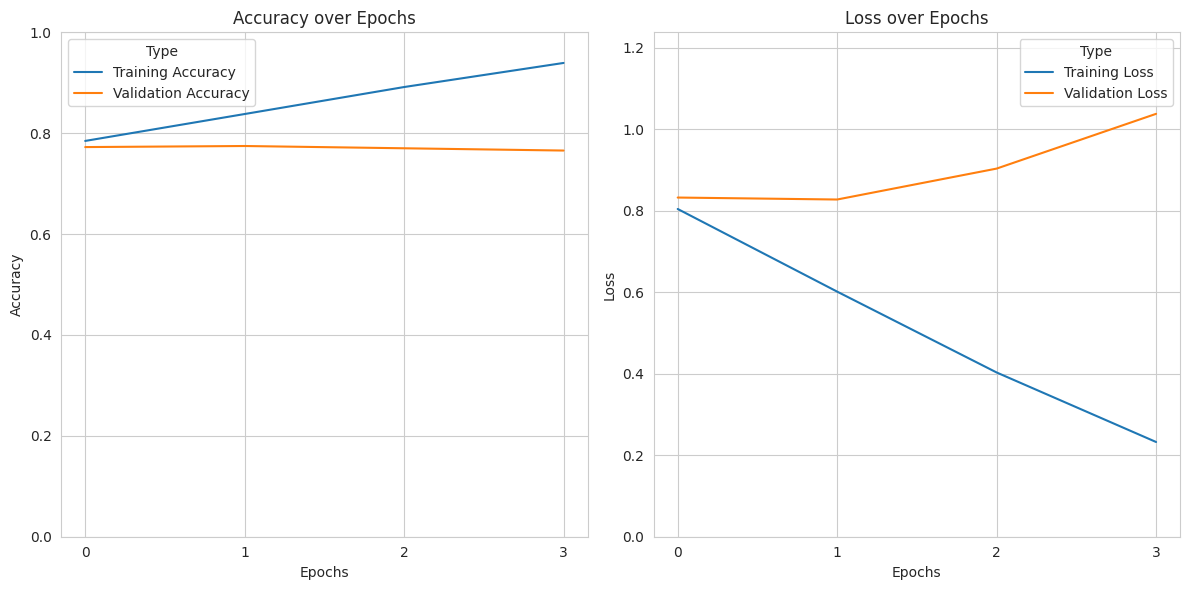

In [61]:
plot_loss_accuracy_curves(fine_tune_l50_history)

In [62]:
model_ft_l50.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 1.0539 - accuracy: 0.7592


[1.0539002418518066, 0.7592079043388367]

### Last and first 50 layers

In [63]:
model_ft_l50_f50 = tf.keras.models.load_model(base_model_path)

In [64]:
check_models_have_close_weights(model_ft_l50_f50, model)

Both models have the same weights in all layers


In [65]:
model_ft_l50_f50.layers[1].trainable = True

In [66]:
for layer in model_ft_l50_f50.layers[1].layers[50:-50]:
    layer.trainable = False

count = 0
for layer in model_ft_l50_f50.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2Bo model: 100


In [67]:
model_ft_l50_f50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [68]:
model_ft_l50_f50.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [69]:
fine_tune_l50_f50_history = model_ft_l50_f50.fit(train_data,
                                                 epochs=4,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=[early_stopping, reduce_lr]
                                                 )

Epoch 1/4
2368/2368 [==============================] - 202s 82ms/step - loss: 0.8034 - accuracy: 0.7832 - val_loss: 0.8087 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 192s 81ms/step - loss: 0.5843 - accuracy: 0.8406 - val_loss: 0.7707 - val_accuracy: 0.7905 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 192s 81ms/step - loss: 0.3883 - accuracy: 0.8931 - val_loss: 0.8230 - val_accuracy: 0.7791 - lr: 1.0000e-04
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 0.2265 - accuracy: 0.9382
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 195s 82ms/step - loss: 0.2265 - accuracy: 0.9382 - val_loss: 0.8896 - val_accuracy: 0.7760 - lr: 1.0000e-04


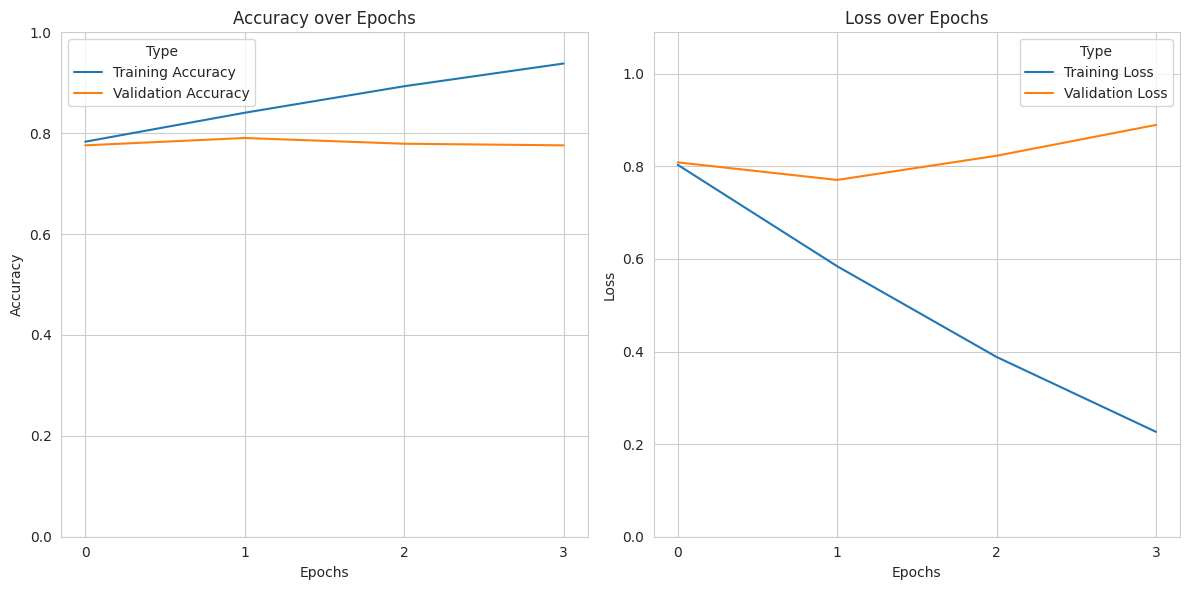

In [70]:
plot_loss_accuracy_curves(fine_tune_l50_f50_history)

In [71]:
model_ft_l50_f50.evaluate(test_data)

790/790 [==============================] - 18s 22ms/step - loss: 0.9339 - accuracy: 0.7730


[0.9338818192481995, 0.7730296850204468]

### All layers

In [72]:
model_ft_all = tf.keras.models.load_model(base_model_path)

In [73]:
check_models_have_close_weights(model_ft_all, model)

Both models have the same weights in all layers


In [74]:
model_ft_all.layers[1].trainable = True

In [75]:
model_ft_all.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [85]:
model_ft_all.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [86]:
fine_tune_all_history = model_ft_all.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 266s 105ms/step - loss: 0.8297 - accuracy: 0.7753 - val_loss: 0.7249 - val_accuracy: 0.8008 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 251s 106ms/step - loss: 0.4813 - accuracy: 0.8658 - val_loss: 0.7093 - val_accuracy: 0.8072 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 249s 105ms/step - loss: 0.2481 - accuracy: 0.9277 - val_loss: 0.8082 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9611
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 247s 104ms/step - loss: 0.1282 - accuracy: 0.9611 - val_loss: 0.8994 - val_accuracy: 0.8016 - lr: 1.0000e-04
